## Sniffer
---
"Sniff out good and bad images in your dataset"

Row(background='#6eb4f5', height=600, sizing_mode='fixed', width=900)
    [0] Column(background='#b9d5f0', height=250, margin=(55, 5), sizing_mode='fixed', width=100)
        [0] Button(button_type='success', margin=(10, 20), name='YES', width=50)
        [1] Button(button_type='danger', margin=(10, 20), name='NO', width=50)
        [2] Button(button_type='warning', margin=(10, 20), name='UNDO', width=35)
    [1] Column(height=500, margin=(0, 0), sizing_mode='fixed', width=500)
        [0] StaticText(margin=(1, 0))
        [1] JPG(str, height=450, sizing_mode='fixed', width=450)
    [2] Column(background='#b9d5f0', height=250, margin=(55, 5), sizing_mode='fixed', width=230)
        [0] RadioButtonGroup(margin=(40, 1), name='Radio Button Group', options=['CSV Mode', 'File Mode'], value='CSV Mode')
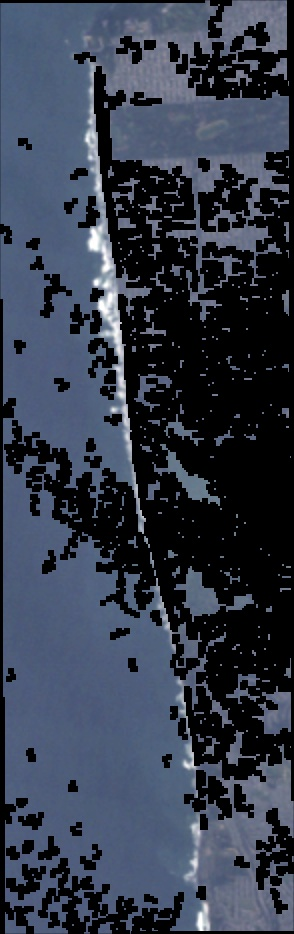

In [4]:
# New import for creating hotkeys
import pynput

import shutil
import panel as pn
import param
import os
import glob
import csv
import pandas as pd
from datetime import datetime
import holoviews as hv
pn.extension()


class SnifferClass(param.Parameterized):
    photo_index                 = param.Integer(0)
    
    # Widgets
    yes_button = pn.widgets.Button(name='YES',width=50,button_type='success',margin=(10,20))
    no_button = pn.widgets.Button(name='NO',width=50,button_type='danger', margin=(10,20))
    undo_button = pn.widgets.Button(name='UNDO',width=35,button_type='warning', margin=(10,20))
    photos_dir_location=os.getcwd()+os.sep + "images"
    list_ = glob.glob(photos_dir_location+os.sep+"*jpg")
    photos_list=map(lambda x:os.path.basename(x),list_ )
    photos_list=list(photos_list)
    last_index_photos_list=len(photos_list) -1
    inital_photo=photos_dir_location+os.sep+photos_list[0]
    jpg_panel=pn.pane.JPG(inital_photo, width=450, height=450,sizing_mode='fixed')
#     jpg_panel=pn.pane.JPG(inital_photo, width=450, height=450,sizing_mode="stretch_both")
    radio_group = pn.widgets.RadioButtonGroup(
        name='Radio Button Group', options=['CSV Mode', 'File Mode'],margin=(40,1))
    
    text = pn.widgets.StaticText(margin=(1,0))

    def __init__(self, **params):
        super().__init__(**params)
        # Variables for images
        self.csv_file_location=""
        self.photos_dir_location=os.getcwd()+os.sep + "images"
        list_ = glob.glob(self.photos_dir_location+os.sep+"*jpg")
        self.photos_list=map(lambda x:os.path.basename(x),list_ )
        self.photos_list=list(self.photos_list)
        self.last_index_photos_list=len(self.photos_list) -1
        self.inital_photo=self.photos_dir_location+os.sep+self.photos_list[0]
        if self.quality_control(self.photos_dir_location,self.photos_list)==False:
            raise FileNotFoundError (f"{self.photos_dir_location} contains no jpgs")
        self.inital_photo=self.photos_dir_location+os.sep+self.photos_list[0]
#         self.undo_button.disabled=True

    def handle_all_images_processed(self):
        """ Check if all images have been processed, if so display the done image"""
        self.text.value = "All images have been processed."
        last_photo=os.getcwd()+os.sep + "assets"+os.sep+"done.jpg"
        self.jpg_panel.object=last_photo
        self.yes_button.disabled=True
        self.no_button.disabled=True
        
        
    def quality_control_failure(self):
        """ Quality control has failed disable all buttons and display error message """
        self.modify_button_state(True)
        self.text.value=f"ERROR: There are no images in\n{photos_dir_location}"
    
    
    def quality_control(self,photos_dir_location,photos_list):
        """Helper function to check if the photos_dir_location exists and that it contains jpgs. Returns false if either check fails"""
        if not os.path.isdir(photos_dir_location):
                os.mkdir(photos_dir_location)
                return False
        bad_images_path=os.getcwd()+os.sep+"bad_images"
        good_images_path=os.getcwd()+os.sep+"good_images"
        if not os.path.exists(bad_images_path):
            os.mkdir(bad_images_path)
        if not os.path.exists(good_images_path):
            os.mkdir(good_images_path) 
        if len(photos_list)==0:
                return False
    #         If neither of these return false it means quality control passed
        return True   

    
    def create_csv(self):
        today = datetime.now()
        d1 = today.strftime("%d_%m_%Y_hr_%H_%M")
        filename=f"Sniffer_Output_"+d1+".csv"
        csv_path = os.getcwd()+os.sep+filename
        with open(csv_path, 'w', newline='') as outcsv:
            writer = csv.writer(outcsv)
            writer.writerow(["Filename", "Sorted","index"])
        return csv_path    


    def delete_image_from_csv(self,filename:str, csv_file: str):
        """Removes the filename from the csv file"""
        if not os.path.exists(csv_file):
            return
        df = pd.read_csv(csv_file)
        # Get the index in the csv where the filename to be removed is located
        index=df.loc[df["Filename"] == filename].index.values
        df.drop(index,axis=0,inplace=True)
        # Delete the csv csv file
        os.remove(csv_file)
        self.text.value=f"{filename}"
        df.to_csv(csv_file, index=False)
    
    
    def delete_image(self,filename:str):
        """Deletes the file called filename from either the good_images or bad_images directory"""
        bad_images_path=os.getcwd()+os.sep+"bad_images"
        good_images_path=os.getcwd()+os.sep+"good_images"
        locations=[bad_images_path,good_images_path]
        # Check if the file exists in either of the directories if it doesn't raise FileNotFound
        for location in locations:
                image_location=self.find_image(location, filename)
                if image_location !=None:
                    os.remove(image_location)
                    return # If the file cannot be found then it proceeds normally


    def find_image(self,file_path:str, filename:str)->str:
        """Looks for the filename (without the extension) in the file_path and returns the location of the file.Otherwise it returns None """
        # Remove the extension from the filename
        filename=os.path.splitext(filename)[0]
        # Check if the directory exists if it doesn't then don't search it
        if os.path.isdir(file_path):
        # See if the filename exists in the directory and return the extact location
            for file in os.listdir(file_path):
                if filename in file:
                    return (file_path+os.sep+file)
            return None


    def copy_image(self,photo_loc:str, sort_type:str):
        """COPY photo_loc to the sorted_images directory with the sort_type appended to the filename"""        
        # Copy the images into the good or bad directories depending on the button clicked
        if "bad" in sort_type:
            sorted_images_path=os.getcwd()+os.sep+"bad_images"
        elif "good" in sort_type:
            sorted_images_path=os.getcwd()+os.sep+"good_images"
        else:
            sorted_images_path=os.getcwd()+os.sep+"sorted_images"
        # Check if the sorted dir exists if it doesn't create it
        if not os.path.isdir(sorted_images_path):
            os.mkdir(sorted_images_path)

        # Change the filename of the photo_loc
        new_filename=self.change_filename(os.path.basename(photo_loc),sort_type,sorted_images_path)

        # Move the image from images into sorted_images
        shutil.copyfile(photo_loc, new_filename)
    

    def change_filename(self,old_filename:str, sort_type:str, photos_dir:str):
        """Appends sort_type to the end of the filename. Returns the location of the file in the location with photos_dir"""
        new_filename=os.path.splitext(old_filename)
        new_filename=new_filename[0]+"_"+str(sort_type)+new_filename[1]
        new_photo_loc=photos_dir+os.sep+new_filename
        return new_photo_loc
    
    def handle_file_choice(self, sort_type:str):
        """Sorts the current file into a good or bad directory depending on the yes/no choice
           when file mode is active
        
        Arguments:
        -----------
        sort_type: str
            -"good": sort the image as a good image
            -"bad": sort the image as a bad image 
        """
        quality_control_passed=self.quality_control(self.photos_dir_location,self.photos_list)
        if not quality_control_passed:
            self.quality_control_failure()
        elif quality_control_passed:
            self.modify_button_state(True)
            self.text.value = f'Saving image #{self.photo_index} as {sort_type}'
            self.save_sorted_image(self.photo_index,sort_type)
            self.photo_index+=1
            # Check if all images have been processed, if so display the done image
            if self.photo_index > self.last_index_photos_list:
                self.handle_all_images_processed()
            # Still more jpgs to check
            else:
                new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                # Update the jpg_panel with the new image
                self.jpg_panel.object=new_photo
                self.text.value = f'Finished saving image #{self.photo_index -1} as {sort_type}'
                self.modify_button_state(False)

    def handle_csv_choice(self, sort_type:str):
        """Sorts the current file as a good or bad type in the csv file depending on the yes/no choice
           when csv mode is active
        
        Arguments:
        -----------
        sort_type: str
            -"good": sort the image as a good image
            -"bad": sort the image as a bad image 
        """
        if not os.path.exists(self.csv_file_location):
                self.csv_file_location=self.create_csv()
        # Save the image filename to the csv file and the type of sort as good
        with open(self.csv_file_location, 'a', newline='') as outcsv:
            writer = csv.writer(outcsv)
            writer.writerow([self.photos_list[self.photo_index], sort_type, self.photo_index])
        self.photo_index+=1
        # Check if all images have been processed, if so display the done image
        if self.photo_index > self.last_index_photos_list:
            self.handle_all_images_processed()
        # Still more jpgs to check
        else:
            self.text.value=f"Save file #{self.photo_index} as {sort_type}"
            new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
            self.jpg_panel.object=new_photo
            self.modify_button_state(False)
                       
                
    def save_sorted_image(self,index,sort_type):
        photo_loc=self.photos_dir_location+os.sep+self.photos_list[index]
        self.copy_image(photo_loc, sort_type)
    
            
    def yes_button_clicked(self,event):
        if (self.radio_group.value == "File Mode"):
             self.handle_file_choice("good")
        elif (self.radio_group.value == "CSV Mode"):
             self.handle_csv_choice("good")
    
    def yes_hotkey(self):
#         print("YES HOTKEY FUNCTION ACTIVATED")
        if (self.radio_group.value == "File Mode"):
             self.handle_file_choice("good")
        elif (self.radio_group.value == "CSV Mode"):
             self.handle_csv_choice("good")
    
    def no_hotkey(self):
#         print("NO HOTKEY FUNCTION ACTIVATED")
        if(self.radio_group.value == "File Mode" ):
             self.handle_file_choice("bad")
        elif (self.radio_group.value == "CSV Mode" ):
             self.handle_csv_choice("bad")

    def  no_button_clicked(self,event):
        if(self.radio_group.value == "File Mode" ):
             self.handle_file_choice("bad")
        elif (self.radio_group.value == "CSV Mode" ):
             self.handle_csv_choice("bad")
    
    def undo_hotkey(self):
#         print("UNDO HOTKEY FUNCTION ACTIVATED")
        if(self.radio_group.value=="File Mode"):
                quality_control_passed=self.quality_control(self.photos_dir_location,self.photos_list)
                if not quality_control_passed:
                    self.quality_control_failure()
                    self.modify_button_state(True)
                    self.text.value = f'Undo last image #{base.photo_index}'
                if self.photo_index == 0 or self.photo_index < 0:
                    self.photo_index = 0
                    self.text.value = f'Cannot undo image. None Left'
                    self.undo_button.disabled=True
                    self.yes_button.disabled=False
                    self.no_button.disabled=False
                else:
                    # Decrease the photo's index so it goes back one 
                    self.photo_index-=1
                    self.text.value = f'Undo last image: {self.photos_list[self.photo_index]} index: {self.photo_index}'
                    # Delete the old file from good or bad directory
                    self.delete_image(self.photos_list[self.photo_index])          
                    # Update the jpg panel
                    new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                    self.jpg_panel.object=new_photo
                    self.text.value = f'Undo completed image #{self.photo_index}'
                    self.modify_button_state(False)
        elif(self.radio_group.value=="CSV Mode"):
                if self.photo_index == 0 or self.photo_index < 0:
                    self.photo_index = 0
                    self.text.value = f'Cannot undo image. None Left'
                    self.undo_button.disabled=True
                    self.yes_button.disabled=False
                    self.no_button.disabled=False
                else:
                    # Decrease the photo's index so it goes back one 
                    self.photo_index-=1
                    self.text.value = f'Undo last image: {self.photos_list[self.photo_index]} index: {self.photo_index}'
                    # Delete the old file from csv
                    self.delete_image_from_csv(self.photos_list[self.photo_index], self.csv_file_location)
                    # Update the jpg panel
                    new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                    self.jpg_panel.object=new_photo
                    self.text.value = f'Undo completed image #{self.photo_index}'
                    self.modify_button_state(False)
    
    def undo_button_clicked(self,event):
        if(self.radio_group.value=="File Mode"):
                quality_control_passed=self.quality_control(self.photos_dir_location,self.photos_list)
                if not quality_control_passed:
                    self.quality_control_failure()
                    self.modify_button_state(True)
                    self.text.value = f'Undo last image #{base.photo_index}'
                if self.photo_index == 0 or self.photo_index < 0:
                    self.photo_index = 0
                    self.text.value = f'Cannot undo image. None Left'
                    self.undo_button.disabled=True
                    self.yes_button.disabled=False
                    self.no_button.disabled=False
                else:
                    # Decrease the photo's index so it goes back one 
                    self.photo_index-=1
                    self.text.value = f'Undo last image: {self.photos_list[self.photo_index]} index: {self.photo_index}'
                    # Delete the old file from good or bad directory
                    self.delete_image(self.photos_list[self.photo_index])          
                    # Update the jpg panel
                    new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                    self.jpg_panel.object=new_photo
                    self.text.value = f'Undo completed image #{self.photo_index}'
                    self.modify_button_state(False)
        elif(self.radio_group.value=="CSV Mode"):
                if self.photo_index == 0 or self.photo_index < 0:
                    self.photo_index = 0
                    self.text.value = f'Cannot undo image. None Left'
                    self.undo_button.disabled=True
                    self.yes_button.disabled=False
                    self.no_button.disabled=False
                else:
                    # Decrease the photo's index so it goes back one 
                    self.photo_index-=1
                    self.text.value = f'Undo last image: {self.photos_list[self.photo_index]} index: {self.photo_index}'
                    # Delete the old file from csv
                    self.delete_image_from_csv(self.photos_list[self.photo_index], self.csv_file_location)
                    # Update the jpg panel
                    new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                    self.jpg_panel.object=new_photo
                    self.text.value = f'Undo completed image #{self.photo_index}'
                    self.modify_button_state(False)


    def modify_button_state(self,is_clickable:bool):
        self.yes_button.disabled=is_clickable
        self.no_button.disabled=is_clickable
        self.undo_button.disabled=is_clickable
        return
    

    
# Make an instance of the Sniffer Class   
sniffer_app = SnifferClass()
sniffer_app.photo_index=0

sniffer_app.yes_button.on_click(sniffer_app.yes_button_clicked)
sniffer_app.no_button.on_click(sniffer_app.no_button_clicked)
sniffer_app.undo_button.on_click(sniffer_app.undo_button_clicked)

from pynput import keyboard

def on_activate_yes():
#     print('<up> pressed')
    sniffer_app.yes_hotkey()

def on_activate_no():
#     print('<down> pressed')
    sniffer_app.no_hotkey()
    
def on_activate_undo():
#     print('<undo> pressed')
    sniffer_app.undo_hotkey()    

listener = keyboard.GlobalHotKeys({
        'a': on_activate_yes,
        'd': on_activate_no,
        's': on_activate_undo})

listener.start()


component = pn.Row(
    pn.Column(sniffer_app.yes_button, sniffer_app.no_button, sniffer_app.undo_button, background='#b9d5f0',width=100,height=250,margin=(55,5)),
    pn.Column(sniffer_app.text, sniffer_app.jpg_panel, height= 500, width=500,margin=(0,0),align='start',sizing_mode='fixed'),
    pn.Column(sniffer_app.radio_group,background='#b9d5f0', width=230,height=250,margin=(55,5)),
    width=900,
    height=600,
    background='#6eb4f5',
    )
component

In [ ]:
# Creates a template that can be served with the command
# panel serve Sniffer.ipynb from the command line
template = pn.template.MaterialTemplate(
    title='',
    logo='assets/sniffer_BIG.png',
    header_background='#B6CCD7',
    main=[component],
)
template.servable();
template